In [8]:
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType
from mlflow import list_run_infos
from urllib.parse import urlparse, unquote_plus
import pandas as pd
import seaborn as sn

In [11]:
# Get experiment
# NOTE: Make sure your CWD is set to the directory where your mlruns/ folder is located.

# import os
# print(os.getcwd()) # Shows the CWD
# os.chdir(NEW_PATH) # Sets the CWD to an arbitrary path.

client = MlflowClient()
experiment = client.get_experiment_by_name("Durable_SA_determ_run_June3_DQNbasic")

In [31]:
exp_id = experiment.experiment_id
runs = list_run_infos(exp_id)
runs = sorted(runs, key=lambda r: r.end_time)
latest_run = runs[-1]
artifact_uri = unquote_plus(urlparse(str(latest_run.artifact_uri)).path)
progress_path = artifact_uri + "/progress.csv"
#print(artifact_uri)
progress = pd.read_csv(progress_path)
progress

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,num_healthy_workers,timesteps_total,agent_timesteps_total,done,episodes_total,...,info/num_target_updates,perf/cpu_util_percent,perf/ram_util_percent,info/learner/default_policy/allreduce_latency,info/learner/default_policy/grad_gnorm,info/learner/default_policy/cur_lr,info/learner/default_policy/mean_q,info/learner/default_policy/min_q,info/learner/default_policy/max_q,info/learner/default_policy/mean_td_error
0,NaN,NaN,NaN,NaN,0,12,1008,1008,False,0,...,1,51.500000,60.50,0.0,10.930940,0.1,0.351552,-0.443828,1.062381,2.608645
1,-213.461122,-293.253994,-249.198359,100.0,24,12,3024,3024,False,24,...,4,42.150000,60.45,0.0,95.835180,0.1,-47.226734,-48.059288,-46.217388,-8.456989
2,-202.647402,-293.253994,-249.623926,100.0,24,12,5040,5040,False,48,...,8,38.350000,60.05,0.0,77.147224,0.1,-26.623180,-30.969227,-24.344919,-2.869802
3,-198.119465,-293.253994,-247.149620,100.0,12,12,7056,7056,False,60,...,12,47.100000,59.45,0.0,26.183079,0.1,-19.058128,-22.313789,-15.062149,-0.420523
4,-198.119465,-309.489010,-249.406633,100.0,24,12,9072,9072,False,84,...,16,44.200000,59.00,0.0,39.066030,0.1,-17.645399,-21.591160,-14.227229,0.636100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2876,-19.210316,-28.976619,-22.847353,100.0,12,12,2996784,2996784,False,29964,...,5674,44.133333,59.00,0.0,0.037869,0.1,-5.887589,-5.974903,-5.862484,-0.030219
2877,-19.210316,-29.134642,-22.418106,100.0,12,12,2997792,2997792,False,29976,...,5676,43.633333,59.00,0.0,0.039140,0.1,-5.827694,-5.845011,-5.806681,-0.021309
2878,-19.210316,-29.134642,-21.619947,100.0,12,12,2998800,2998800,False,29988,...,5678,43.633333,59.00,0.0,0.062804,0.1,-5.766457,-5.905853,-5.736855,0.042403
2879,-19.210316,-29.134642,-21.619947,100.0,0,12,2999808,2999808,False,29988,...,5680,42.700000,59.00,0.0,0.069868,0.1,-5.658591,-5.792285,-5.646412,0.053735


<AxesSubplot:xlabel='episodes_total', ylabel='episode_reward_mean'>

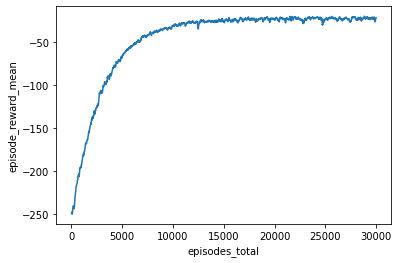

In [13]:
sn.lineplot(data=progress, x="episodes_total",y="episode_reward_mean")

In [32]:
#Step 4: Evaluation
from marketsai.markets.durable_sa_determ import Durable_SA_determ
from ray.rllib.agents.dqn import DQNTrainer
from ray.tune.registry import register_env
from ray import shutdown, init

shutdown()
init(num_cpus=1)

register_env("Durable_SA_determ", Durable_SA_determ)
env = Durable_SA_determ()
#config

# Training config (for the algorithm)
common_config = {
    # common_config
    #"gamma": 0.95,
    # "lr": tune.grid_search([0.00025, 0.1]),
    #"lr": 0.1,
    "env": "Durable_SA_determ",
    #"horizon": 100,
    #"soft_horizon": True,
    #"no_done_at_end": True,
    "exploration_config": {"explore": False},
    #"framework": "torch",
    "normalize_actions": False,
    "log_level": "ERROR",
}

checkpoint_path = "/⁨Users⁩/⁨matiascovarrubias⁩/ray_results⁩/⁨Durable_SA_determ_run_June3_DQNbasic⁩/⁨DQN_Durable_SA_determ_7dea0_00000_0_2021-06-03_17-13-07⁩/checkpoint_002881/checkpoint-2881⁩"
trained_trainer = DQNTrainer(env = "Durable_SA_determ", config= {"explore": False})
trained_trainer.restore(checkpoint_path)
inv_list = []
h_list = []
rew_list = []
obs = env.reset()
MAX_STEP=100
for i in range(MAX_STEPS):
    action= trained_trainer.compute_action(obs)
    obs, reward, done, info = env.step(action)
    inv_list.append(info["investment"])
    h_list.append(obs)
    rew_list.append(rew)

shutdown()
plt.ion()

plt.plot(inv_list)
plt.show()
plt.plot(h_list)
plt.show()
plt.plot(rew_list)
plt.show()

IRresults = {
    "investment": inv,
    "durable_stock": h_list,
    "reward": rew_list,
}
df_IR = pd.DataFrame(IRresults)
df_IR.to_csv("Durable_SA_determ_June3_DQN.csv")

2021-06-03 20:20:08,662	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:8265
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ra

FileNotFoundError: [Errno 2] No such file or directory: '/\u2068Users\u2069/\u2068matiascovarrubias\u2069/ray_results\u2069/\u2068Durable_SA_determ_run_June3_DQNbasic\u2069/\u2068DQN_Durable_SA_determ_7dea0_00000_0_2021-06-03_17-13-07\u2069/checkpoint_002881/checkpoint-2881\u2069.tune_metadata'